In [37]:
from collections import Counter
from sm.linear_algebra import distance, vector_subtract, scalar_multiply
from functools import reduce, partial
import math, random

In [9]:
from matplotlib import pyplot as plt

In [33]:
def sum_of_squares(v):
    return sum(v_i ** 2 for v_i in v)

#### Estimate the gradient

In [6]:
def difference_quotient(f, x, h):
    return (f(x + h) - f(x) / h)

RuntimeError: matplotlib does not support generators as input

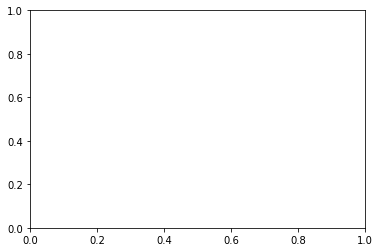

In [39]:
def square(x):
        return x * x;

def derivative(x):
    return 2 * x;

derivative_estimate = partial(difference_quotient, square, h=0.00001) 

x = range(-10,10)
plt.plot(x, map(derivative, x), 'rx', label='Actual')           # red  x
plt.plot(x, map(derivative_estimate, x), 'b+', label='Estimate')  # blue +
plt.legend(loc=9)
plt.show()                                      # purple *, hopefully

In [28]:
def partial_difference_quotient(f, v, i, h):

    # add h to just the i-th element of v
    w = [v_j + (h if j == i else 0)
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

In [29]:
def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
            for i, _ in enumerate(v)]

#### Using Gradient

In [30]:
def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

In [31]:
def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

In [41]:
# pick a random starting point

v = [random.randint(-10, 10) for i in range(3)]

In [43]:
v

[1, -2, -3]

In [45]:
tolerance = 0.0000001

In [47]:
while True:
    #print v, sum_of_squares(v)
    gradient = sum_of_squares_gradient(v)   # compute the gradient at v
    next_v = step(v, gradient, -0.01)       # take a negative gradient step
    if distance(next_v, v) < tolerance:     # stop if we're converging
        break
    v = next_v                              # continue if we're not

In [49]:
gradient

[2.645457017387243e-06, -5.290914034774486e-06, -7.936371052161734e-06]

In [51]:
v

[1.3227285086936214e-06, -2.645457017387243e-06, -3.968185526080867e-06]

#### Choosing the right step size

In [55]:
def safe(f):
    """define a new function that wraps f and return it"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')         # this means "infinity" in Python
    return safe_f

In [69]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

    theta = theta_0                           # set theta to initial value
    target_fn = safe(target_fn)               # safe version of target_fn
    value = target_fn(theta)                  # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

In [75]:
v = [random.randint(-10,10) for i in range(3)]

In [76]:
v

[-9, -4, -9]

In [77]:
v = minimize_batch(sum_of_squares, sum_of_squares_gradient, v)

In [78]:
v

[-0.0009570441569651392, -0.00042535295865117324, -0.0009570441569651392]

In [58]:
def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

In [60]:
def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

In [62]:
def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,
                          tolerance)

#### Stochastic Gradient Descent

In [65]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

In [67]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

In [81]:
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)